In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as knn

In [2]:
# load data
train_in = np.loadtxt('./Datasets/train_in.csv', 
                  delimiter=',',  
                  skiprows=0,      
                  dtype=float)       
test_in = np.loadtxt('./Datasets/test_in.csv', 
                  delimiter=',',   
                  skiprows=0,      
                  dtype=float)       
train_out = np.loadtxt('./Datasets/train_out.csv', 
                  delimiter=',',  
                  skiprows=0,      
                  dtype=float)       
test_out = np.loadtxt('./Datasets/test_out.csv', 
                  delimiter=',',   
                  skiprows=0,      
                  dtype=float)       

In [3]:
# adding additional 1 to datasets
def preprocessing(datasets):
    return np.hstack((datasets, np.ones(len(datasets)).reshape(len(datasets),1)))

In [4]:
# transforming vector to dummy matrix
def get_dummies(list, array):
    for i, each in zip(list, array):
        each[int(i)] = 1
    return array

In [5]:
# sigmoid function 
def sig(x):
    return (1/(1+np.exp(-x)))

def sig_prime(x):
    return (x * (1 - x))

In [6]:
# preprocessing train_in, train_out, test_in, test_out
X_train, X_val, y_train, y_val = train_test_split(train_in, train_out, train_size=0.8, random_state=0)
X_test = test_in
y_test = test_out
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
print('Inputs_train', )

Len_train = len(X_train)
Len_val = len(X_val)
Len_test = len(X_test)

X_train = preprocessing(X_train)
X_val = preprocessing(X_val)
X_test = preprocessing(X_test)

y_train_dummy = np.zeros(Len_train*10).reshape(Len_train, 10)
y_train_dummy = get_dummies(y_train, y_train_dummy)
y_val_dummy = np.zeros(Len_val*10).reshape(Len_val, 10)
y_val_dummy = get_dummies(y_val, y_val_dummy)
y_test_dummy = np.zeros(Len_test*10).reshape(Len_test, 10)
y_test_dummy = get_dummies(y_test, y_test_dummy)

(1365, 256) (342, 256) (1365,) (342,)
Inputs_train


In [7]:
# 5-fold splits
kf = KFold(n_splits=5)
kfold_index_list = []
for cv_index_train, cv_index_test in kf.split(X_train):
    kfold_index_list.append((cv_index_train, cv_index_test))

In [8]:
# training function, stop with acc > 0.97 or iter > 999
def training(lr, w, x, y_dummy):
    for iter in range(1000):
        for i in range(len(x)):
            y_hat = sig(np.dot(x[i], w))
            diff = y_dummy[i] - y_hat
            x_re = x[i].reshape(257,1)
            # print(y_hat)
            sp = sig_prime(y_hat) * diff
            w += lr * x_re * sp

        if iter % 10 == 0 :
            arg_y_hat = np.argmax(sig(np.dot(x, w)), axis=1)
            arg_y_dummy = np.argmax(y_dummy, axis=1)
            arg_diff = abs(arg_y_dummy - arg_y_hat)
            acc = (len(y_dummy)-np.sum(arg_diff>0))/len(y_dummy)
            # print(sum(arg_diff))
        if acc > 0.97:
            print('iter', iter)
            break
    return w

In [9]:
def predict(lr, w, train_x, y_train_dummy):
    y_hat = sig(np.dot(train_x, w))
    return np.argmax(y_hat, axis=1)

In [10]:
# generate w0 with different weights distribution
def generate_w0(sections):
    np.random.seed(2022)
    W_experiments = np.zeros(257*10*len(sections)).reshape(len(sections), 257,10)
    index = 0
    for i in sections:
        # print(i[0], i[1])
        W_experiments[index] = np.random.uniform(i[0], i[1], size=(257,10))
        index += 1
    return W_experiments

In [11]:
# calculate accuracy on val, test set (with in put w)
def generate_acc(w):
    pred_val = predict(lr, w, X_val, y_val_dummy)
    acc_val = accuracy_score(y_val, pred_val)

    pred_test = predict(lr, w, X_test, y_test_dummy)
    acc_test = accuracy_score(y_test, pred_test)

    return acc_val, acc_test

In [12]:
# training on uniform weights (-1, 1), (-0.5, 0.5), (-0.3, 0.3), (-0.1, 0.1)
w_list = []
results = []
w_list.clear()
results.clear()
np.random.seed(2022)
sections = [(-1, 1), (-0.5, 0.5), (-0.3, 0.3), (-0.1, 0.1)]
lr = 0.3
W_experiments = generate_w0(sections)

for w0_index in range(len(sections)):
    print(w0_index)
    w0 = W_experiments[w0_index]
    w = training(lr, w0, X_train, y_train_dummy)
    
    pred_train = predict(lr, w, X_train, y_train_dummy)
    acc_train = accuracy_score(y_train, pred_train)
    acc_val, acc_test = generate_acc(w)

    w_list.append(w)
    results.append((acc_train, acc_val, acc_test))
for i in range(len(sections)):
    acc, acc_val, acc_test = results[i]
    print("Training with weights section: ", sections[i])
    print("Accuracy train: ", acc, "Accuracy validation", acc_val, "Accuracy test", acc_test)

0
1
iter 180
2
iter 50
3
iter 30
Training with weights section:  (-1, 1)
Accuracy train:  0.7677655677655678 Accuracy validation 0.7573099415204678 Accuracy test 0.695
Training with weights section:  (-0.5, 0.5)
Accuracy train:  0.9736263736263736 Accuracy validation 0.956140350877193 Accuracy test 0.887
Training with weights section:  (-0.3, 0.3)
Accuracy train:  0.9706959706959707 Accuracy validation 0.9590643274853801 Accuracy test 0.888
Training with weights section:  (-0.1, 0.1)
Accuracy train:  0.9714285714285714 Accuracy validation 0.956140350877193 Accuracy test 0.883


In [13]:
# training on normal weights (0, 0.3)
lr = 0.3
w_list = []
results = []
w_list.clear()
results.clear()
np.random.seed(2022)
w0 = np.random.normal(loc=0.0, scale=0.3, size=(257, 10))
w = training(lr, w0, X_train, y_train_dummy)

pred_train = predict(lr, w, X_train, y_train_dummy)
acc_train = accuracy_score(y_train, pred_train)
acc_val, acc_test = generate_acc(w)

w_list.append(w)

print("Training with weights section: ", 'Completely random')
print("Accuracy train: ", acc_train, "Accuracy validation", acc_val, "Accuracy test", acc_test)

iter 160
Training with weights section:  Completely random
Accuracy train:  0.9721611721611721 Accuracy validation 0.9502923976608187 Accuracy test 0.89


In [14]:
# training on normal weights (0, 0.5)
w_list = []
results = []
w_list.clear()
results.clear()
np.random.seed(2022)
w0 = np.random.normal(loc=0.0, scale=0.5, size=(257, 10))
w = training(lr, w0, X_train, y_train_dummy)

pred_train = predict(lr, w, X_train, y_train_dummy)
acc_train = accuracy_score(y_train, pred_train)
acc_val, acc_test = generate_acc(w)

w_list.append(w)

print("Training with weights section: ", 'Completely random')
print("Accuracy train: ", acc_train, "Accuracy validation", acc_val, "Accuracy test", acc_test)

Training with weights section:  Completely random
Accuracy train:  0.8974358974358975 Accuracy validation 0.8888888888888888 Accuracy test 0.811


In [15]:
# training on normal weights (0, 0.1)
w_list = []
results = []
w_list.clear()
results.clear()
np.random.seed(2022)
w0 = np.random.normal(loc=0.0, scale=0.1, size=(257, 10))
w = training(lr, w0, X_train, y_train_dummy)

pred_train = predict(lr, w, X_train, y_train_dummy)
acc_train = accuracy_score(y_train, pred_train)
acc_val, acc_test = generate_acc(w)

w_list.append(w)

print("Training with weights section: ", 'Completely random')
print("Accuracy train: ", acc_train, "Accuracy validation", acc_val, "Accuracy test", acc_test)

iter 20
Training with weights section:  Completely random
Accuracy train:  0.9714285714285714 Accuracy validation 0.9532163742690059 Accuracy test 0.888


In [16]:
# training on normal weights (0, 1)
w_list = []
results = []
w_list.clear()
results.clear()
np.random.seed(2022)
w0 = np.random.normal(loc=0.0, scale=1, size=(257, 10))
w = training(lr, w0, X_train, y_train_dummy)

pred_train = predict(lr, w, X_train, y_train_dummy)
acc_train = accuracy_score(y_train, pred_train)
acc_val, acc_test = generate_acc(w)

w_list.append(w)

print("Training with weights section: ", 'Completely random')
print("Accuracy train: ", acc_train, "Accuracy validation", acc_val, "Accuracy test", acc_test)

Training with weights section:  Completely random
Accuracy train:  0.7230769230769231 Accuracy validation 0.7426900584795322 Accuracy test 0.657


In [17]:
# training on weights = 0
w0 = np.zeros(257*10).reshape(257, 10)
w = training(lr, w0, X_train, y_train_dummy)

pred_train = predict(lr, w, X_train, y_train_dummy)
acc_train = accuracy_score(y_train, pred_train)
acc_val, acc_test = generate_acc(w)

w_list.append(w)

print("Training with weights section: ", '0, 0')
print("Accuracy train: ", acc_train, "Accuracy validation", acc_val, "Accuracy test", acc_test)

iter 40
Training with weights section:  0, 0
Accuracy train:  0.9714285714285714 Accuracy validation 0.9619883040935673 Accuracy test 0.876


In [18]:
# cross-validation on normal weights (0, 0.3)
np.random.seed(2022)
w0 = np.random.normal(loc=0.0, scale=0.3, size=(257, 10))
lr = 0.3
w_list.clear()
results.clear()
for i in range(5):
    w = training(lr, w0, X_train[kfold_index_list[i][0]], y_train_dummy[kfold_index_list[i][0]])

    pred_train = predict(lr, w, X_train[kfold_index_list[i][1]], y_train_dummy[kfold_index_list[i][1]])
    acc_train = accuracy_score(y_train[kfold_index_list[i][1]], pred_train)

    pred_val = predict(lr, w, X_val, y_val_dummy)
    acc_val = accuracy_score(y_val, pred_val)

    pred_test = predict(lr, w, X_test, y_test_dummy)
    acc_test = accuracy_score(y_test, pred_test)

    w_list.append(w)
    results.append((acc_train, acc_val, acc_test))

for acc, acc_val, acc_test in results:
    print("Accuracy train: ", acc, "Accuracy validation", acc_val, "Accuracy test", acc_test)


iter 80
iter 0
iter 0
iter 10
iter 90
Accuracy train:  0.945054945054945 Accuracy validation 0.956140350877193 Accuracy test 0.883
Accuracy train:  0.9560439560439561 Accuracy validation 0.956140350877193 Accuracy test 0.885
Accuracy train:  0.9706959706959707 Accuracy validation 0.9532163742690059 Accuracy test 0.883
Accuracy train:  0.9743589743589743 Accuracy validation 0.9532163742690059 Accuracy test 0.887
Accuracy train:  0.9816849816849816 Accuracy validation 0.9444444444444444 Accuracy test 0.888


iter 160


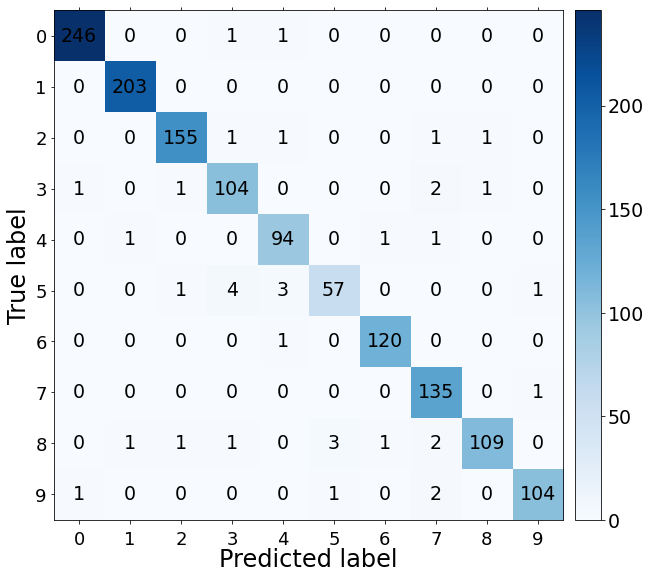

In [19]:
# confusion martix on train set
np.random.seed(2022)
w0 = np.random.normal(loc=0.0, scale=0.3, size=(257, 10))
w = training(lr, w0, X_train, y_train_dummy)

plt.rc('figure',figsize=(11,11)) 
cm = confusion_matrix(y_train, predict(lr, w, X_train, y_train_dummy)) 
plt.matshow(cm,cmap=plt.cm.Blues) 
cm_x_ticks=[0,1,2,3,4,5,6,7,8,9] 
for i in range(cm.shape[0]): 
  for j in range(cm.shape[1]): 
    plt.text(x=j, y=i, s=cm[i, j], 
fontsize=19,ha='center',va='center') 
my_x_ticks = [0,1,2,3,4,5,6,7,8,9] 
my_y_ticks = [0,1,2,3,4,5,6,7,8,9] 
plt.xticks(my_x_ticks, size=18, verticalalignment='bottom', y=-0.07) 
plt.yticks(my_y_ticks, size=18) 
plt.xlabel('Predicted label',fontdict={'fontsize':24}, labelpad=28 ) 
plt.ylabel('True label',fontdict={'fontsize':24})
plt.rcParams['font.size'] = 19
plt.colorbar(pad=0.02,shrink=0.83)

iter 160


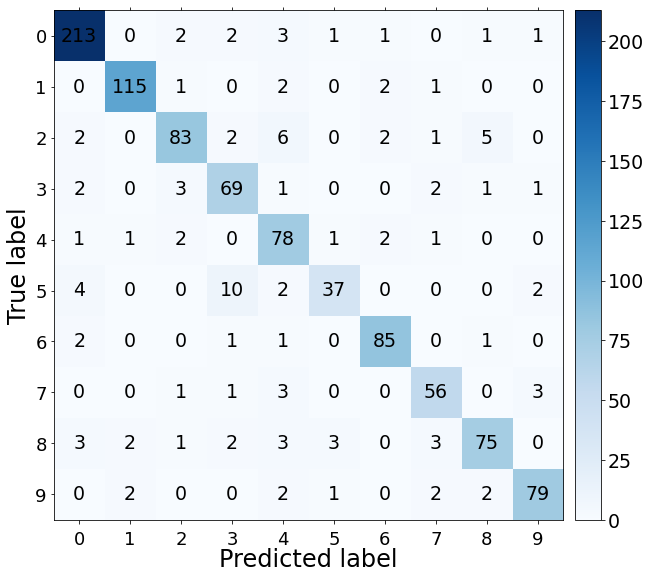

In [20]:
## # confusion martix on test set
np.random.seed(2022)
w0 = np.random.normal(loc=0.0, scale=0.3, size=(257, 10))
w = training(lr, w0, X_train, y_train_dummy)

plt.rc('figure',figsize=(11,11)) 
cm = confusion_matrix(y_test, predict(lr, w, X_test, y_test_dummy)) 
plt.matshow(cm,cmap=plt.cm.Blues) 
cm_x_ticks=[0,1,2,3,4,5,6,7,8,9] 
for i in range(cm.shape[0]): 
  for j in range(cm.shape[1]): 
    plt.text(x=j, y=i, s=cm[i, j], 
fontsize=19,ha='center',va='center') 
my_x_ticks = [0,1,2,3,4,5,6,7,8,9] 
my_y_ticks = [0,1,2,3,4,5,6,7,8,9] 
plt.xticks(my_x_ticks, size=18, verticalalignment='bottom', y=-0.07) 
plt.yticks(my_y_ticks, size=18) 
plt.xlabel('Predicted label',fontdict={'fontsize':24}, labelpad=28 ) 
plt.ylabel('True label',fontdict={'fontsize':24})
plt.rcParams['font.size'] = 19
plt.colorbar(pad=0.02,shrink=0.83)

## Compare

In [21]:
# generating a each number test set
test_in_sort = np.hstack((test_in, test_out.reshape(1000,1)))
test_in_sort = test_in_sort[test_in_sort[:,-1].argsort()]
test_in_sort[:,-1] = 1
test_out_sort = sorted(test_out)

s = 0
index_test = []
for i in range(len(test_out_sort)):
    if test_out_sort[i] > s:
        index_test.append(i-1)
        s += 1
index_test.append(1000)

In [22]:
# kNN result
knn_model = knn()
model_knn = knn_model.fit(train_in,train_out)
test_pred_knn = model_knn.predict(test_in)

In [23]:
# compare SLMP, KNN, DBC, SDBC on each number test set
np.random.seed(2022)
w0 = np.random.normal(loc=0.0, scale=0.3, size=(257, 10))

train_in_p = preprocessing(train_in)
train_out_dummy = np.zeros(len(train_out)*10).reshape(len(train_out), 10)
train_out_dummy = get_dummies(train_out, train_out_dummy)

w = training(lr, w0, train_in_p, train_out_dummy)

test_out_sort_dummy = np.zeros(Len_test*10).reshape(Len_test, 10)
test_out_sort_dummy = get_dummies(test_out_sort, test_out_sort_dummy)

start = 0

index = 0
for end in index_test:
    each_test_in = test_in_sort[:][start:end]
    each_test_out = test_out_sort[:][start:end]
    each_test_out_sort_dummy = test_out_sort_dummy[:][start:end]

    pred_test = predict(lr, w, each_test_in, each_test_out_sort_dummy)
    pred_test_knn = model_knn.predict(each_test_in[:, 0:-1])
    # pred_test_D = D_classify111(dataset=each_test_in[:, 0:-1])

    acc_test = accuracy_score(each_test_out, pred_test)
    acc_test_knn = accuracy_score(each_test_out, pred_test_knn)
    # acc_test_D = accuracy_score(each_test_out, pred_test_D)
    print("number:",index,"Accuracy test", "single layer perceptron",acc_test, "knn",acc_test_knn)

    index += 1
    start = end

test_out_dummy = np.zeros(Len_test*10).reshape(Len_test, 10)
test_out_dummy = get_dummies(test_out, test_out_dummy)
test_in_p = preprocessing(test_in)


pred_test = predict(lr, w, test_in_p, test_out_dummy)
pred_test_knn = model_knn.predict(test_in)
# pred_test_D = D_classify111(dataset=test_in)

acc_test = accuracy_score(test_out, pred_test)
acc_test_knn = accuracy_score(test_out, pred_test_knn)
# acc_test_D = accuracy_score(test_out, pred_test_D)
print("Accuracy test", "single layer perceptron",acc_test, "knn",acc_test_knn)

iter 280
number: 0 Accuracy test single layer perceptron 0.9641255605381166 knn 0.9775784753363229
number: 1 Accuracy test single layer perceptron 0.9669421487603306 knn 0.9834710743801653
number: 2 Accuracy test single layer perceptron 0.7920792079207921 knn 0.8415841584158416
number: 3 Accuracy test single layer perceptron 0.810126582278481 knn 0.8734177215189873
number: 4 Accuracy test single layer perceptron 0.8837209302325582 knn 0.9186046511627907
number: 5 Accuracy test single layer perceptron 0.7272727272727273 knn 0.6545454545454545
number: 6 Accuracy test single layer perceptron 0.9555555555555556 knn 0.9333333333333333
number: 7 Accuracy test single layer perceptron 0.875 knn 0.875
number: 8 Accuracy test single layer perceptron 0.7391304347826086 knn 0.8586956521739131
number: 9 Accuracy test single layer perceptron 0.9213483146067416 knn 0.9325842696629213
Accuracy test single layer perceptron 0.884 knn 0.908
